# Gateway Food-Web Dataset — Python EDA & Export

This notebook turns the “gateway” food-web spreadsheet into tidy, Python-ready artefacts and gives a transparent overview of the data structure across webs.

## Goals
1. **Ingest & clean** a large gateway file (CSV/Excel) with an explicit schema:
   - Predator = `con.taxonomy`, Prey = `res.taxonomy`, Web ID = `foodweb.name`.
   - Remove self-loops and duplicate directed pairs within each web.
2. **Quantify structure** at two levels:
   - **Global**: number of food webs, unique species, total directed links.
   - **Per-web**: S (species), L (links), connectance (L/S²), in/out/total-degree stats, and mean trophic level.
3. **Compute trophic levels** using the linear system on a predator→prey graph:
   - \((I - D) s = \mathbf{1}\) with basal species fixed to \(s=1\), where \(D\) is row-normalised by predator out-degree.
4. **Optional geospatial sanity check**:
   - Small interactive map of sampling locations using Folium or Plotly (lightweight).
5. **Export Python-friendly artefacts** for downstream work and sharing:
   - `edges.parquet`, `nodes.parquet`, `per_web_summary.parquet`, `trophic_levels.parquet`.
   - One `*.graphml` per web (for NetworkX/Gephi).

## How to run
1. Set `INPUT_PATH` to your full dataset (keep the sample first to smoke-test).
2. Run cells top-to-bottom. Optional mapping step requires **folium** or **plotly**.
3. Find outputs in `./gateway_processed/`.

## 0) Optional: install deps (skip if you already have them)

In [1]:
# %pip install -q pandas numpy pyarrow networkx matplotlib seaborn folium plotly

## 1) Imports, display options, and paths

In [2]:
import os
import re
import math
import folium
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)
sns.set_theme(style="whitegrid", font_scale=1.2)

# Point to your file here.
# INPUT_PATH = './food_web_10.csv'
INPUT_PATH = '../../../data/raw/283_3_Dataset/283_2_FoodWebDataBase_2018_12_10.csv'

# Optional output directory for processed Python-friendly artefacts
OUT_DIR = "./gateway_processed"
os.makedirs(OUT_DIR, exist_ok=True)

## 2) Loader that works for CSV or Excel and standardises columns

In [3]:
raw_df = pd.read_csv(INPUT_PATH, low_memory=False)
raw_df.head(10)

,autoID,link.citation,link.methodology,interaction.type,interaction.dimensionality,interaction.classification,con.taxonomy,con.taxonomy.level,con.common,con.lifestage,con.metabolic.type,con.movement.type,con.size.citation,con.size.method,con.length.min.cm.,con.length.mean.cm.,con.length.max.cm.,con.mass.min.g.,con.mass.mean.g.,con.mass.max.g.,res.taxonomy,res.taxonomy.level,res.common,res.lifestage,res.metabolic.type,res.movement.type,res.size.citation,res.size.method,res.length.min.cm.,res.length.mean.cm.,res.length.max.cm.,res.mass.min.g.,res.mass.mean.g.,res.mass.max.g.,geographic.location,longitude,latitude,ecosystem.type,study.site,altitude,depth,sampling.time,sampling.start.year,sampling.end.year,notes,foodweb.name
0,1,Cattin Blandenier (2004),published account internet field natural history,predacious,NaN,ibi,Vulpes vulpes,NaN,NaN,NaN,endotherm vertebrate,walking,Cattin Blandenier (2004),measurement published account regression,-999,-999.0,-999,-999,5000.0,-999,Tipulidae,family,NaN,larvae,invertebrate,walking,Cattin Blandenier (2004),measurement published account regression,-999,-999.0,-999,-999,0.005316,-999,"Switzerland, Lake Neuchatel",6.98182,46.93845,terrestrial aboveground,Grand Caricaie,-999.0,-999.0,NaN,NaN,NaN,NaN,Grand Caricaie marsh dominated by Cladietum m...
1,2,Cattin Blandenier (2004),published account internet field natural history,predacious,2D,ibi,Emberiza schoeniclus,species,NaN,NaN,endotherm vertebrate,flying,Cattin Blandenier (2004),measurement published account regression,-999,-999.0,-999,-999,20.0,-999,Coleoptera,NaN,NaN,larvae,invertebrate,walking,Cattin Blandenier (2004),measurement published account regression,-999,-999.0,-999,-999,0.000038,-999,"Switzerland, Lake Neuchatel",6.98182,46.93845,terrestrial aboveground,Grand Caricaie,-999.0,-999.0,NaN,NaN,NaN,NaN,Grand Caricaie marsh dominated by Cladietum m...
2,3,Cattin Blandenier (2004),published account internet field natural history,predacious,2D,ibi,Emberiza schoeniclus,species,NaN,NaN,endotherm vertebrate,flying,Cattin Blandenier (2004),measurement published account regression,-999,-999.0,-999,-999,20.0,-999,Araneidae,family,NaN,immature,invertebrate,walking,Cattin Blandenier (2004),measurement published account regression,-999,-999.0,-999,-999,0.000112,-999,"Switzerland, Lake Neuchatel",6.98182,46.93845,terrestrial aboveground,Grand Caricaie,-999.0,-999.0,NaN,NaN,NaN,NaN,Grand Caricaie marsh dominated by Cladietum m...
3,4,Cattin Blandenier (2004),published account internet field natural history,predacious,2D,ibi,Vulpes vulpes,NaN,NaN,NaN,endotherm vertebrate,walking,Cattin Blandenier (2004),measurement published account regression,-999,-999.0,-999,-999,5000.0,-999,Tettigoniidae,family,NaN,larvae,invertebrate,walking,Cattin Blandenier (2004),measurement published account regression,-999,-999.0,-999,-999,0.030211,-999,"Switzerland, Lake Neuchatel",6.98182,46.93845,terrestrial aboveground,Grand Caricaie,-999.0,-999.0,NaN,NaN,NaN,NaN,Grand Caricaie marsh dominated by Cladietum m...
4,5,Cattin Blandenier (2004),published account internet field natural history,predacious,3D,ibi,Emberiza schoeniclus,species,NaN,NaN,endotherm vertebrate,flying,Cattin Blandenier (2004),measurement published account regression,-999,-999.0,-999,-999,20.0,-999,Chironomidae,family,NaN,NaN,invertebrate,flying,Cattin Blandenier (2004),measurement published account regression,-999,-999.0,-999,-999,0.000163,-999,"Switzerland, Lake Neuchatel",6.98182,46.93845,terrestrial aboveground,Grand Caricaie,-999.0,-999.0,NaN,NaN,NaN,NaN,Grand Caricaie marsh dominated by Cladietum m...
5,6,Cattin Blandenier (2004),published account internet field natural history,predacious,2D,ibi,Vulpes vulpes,NaN,NaN,NaN,endotherm vertebrate,walking,Cattin Blandenier (2004),measurement published account regression,-999,-999.0,-999,-999,5000.0,-999,Acrididae,family,NaN,larvae,invertebrate,walking,Cattin Blandenier (2004),measurement published account regression,-999,-999.0,-999,-999,0.041023,-999,"Swi

## 3) Identify explicit column map predator/prey/web columns

In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222151 entries, 0 to 222150
Data columns (total 46 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   autoID                      222151 non-null  int64  
 1   link.citation               222151 non-null  object 
 2   link.methodology            65980 non-null   object 
 3   interaction.type            220177 non-null  object 
 4   interaction.dimensionality  203777 non-null  object 
 5   interaction.classification  221249 non-null  object 
 6   con.taxonomy                222151 non-null  object 
 7   con.taxonomy.level          214126 non-null  object 
 8   con.common                  57159 non-null   object 
 9   con.lifestage               138535 non-null  object 
 10  con.metabolic.type          222151 non-null  object 
 11  con.movement.type           222120 non-null  object 
 12  con.size.citation           47387 non-null   object 
 13  con.size.metho

In [5]:
# ==== Explicit columns from your CSV ====
PREDATOR_COL                  = "con.taxonomy"
PREDATOR_TAXLEVEL_COL         = "con.taxonomy.level"
PREDATOR_METABOLIC_COL        = "con.metabolic.type"
PREDATOR_MOVEMENT_COL         = "con.movement.type"
PREDATOR_LENGTH_MEAN_CM_COL   = "con.length.mean.cm."
PREDATOR_MASS_MEAN_G_COL      = "con.mass.mean.g."

PREY_COL                      = "res.taxonomy"
PREY_TAXLEVEL_COL             = "res.taxonomy.level"
PREY_METABOLIC_COL            = "res.metabolic.type"
PREY_MOVEMENT_COL             = "res.movement.type"
PREY_LENGTH_MEAN_CM_COL       = "res.length.mean.cm."
PREY_MASS_MEAN_G_COL          = "res.mass.mean.g."

WEB_COL                       = "foodweb.name"
ECO_COL                       = "ecosystem.type"
SITE_COL                      = "study.site"
GEOLOC_COL                    = "geographic.location"
LON_COL                       = "longitude"
LAT_COL                       = "latitude"
ALT_COL                       = "altitude"
DEPTH_COL                     = "depth"

INTERACTION_TYPE_COL          = "interaction.type"
INTERACTION_CLASS_COL         = "interaction.classification"
INTERACTION_DIM_COL           = "interaction.dimensionality"
CITATION_COL                  = "link.citation"
METHOD_COL                    = "link.methodology"

## 4) Minimal cleaning + optional filtering of interaction type/class

In [6]:
df = raw_df.copy()

# Standardize edge endpoints (required)
for c in [PREDATOR_COL, PREY_COL]:
    df[c] = df[c].astype(str).str.strip()

# Drop empty names and self loops
df = df[(df[PREDATOR_COL] != "") & (df[PREY_COL] != "")]
df = df[df[PREDATOR_COL] != df[PREY_COL]]

In [7]:
# (Optional) Inspect and filter interaction types/classes if needed
print("Unique interaction.type:", sorted(df[INTERACTION_TYPE_COL].dropna().unique().tolist()))
print("Unique interaction.classification:", sorted(df[INTERACTION_CLASS_COL].dropna().unique().tolist()))

Unique interaction.type: ['bacterivorous', 'detritivorous', 'fungivorous', 'herbivorous', 'parasitic', 'parasitoid', 'predacious']
Unique interaction.classification: ['ibi', 'nibi']


In [8]:
# Deduplicate by web + directed pair
df = df.drop_duplicates(subset=[WEB_COL, PREDATOR_COL, PREY_COL])
df.shape

(217562, 46)

In [9]:
# Count unique food webs
df[WEB_COL].value_counts()

foodweb.name
Weddell Sea         15989
Chesapeake Bay      15679
Lough Hyne           5039
FloridaIslandE3      3658
FloridaIslandE1      3549
                    ...  
SP1                    20
Brook trout lake       19
Twin Lake East         16
SF1M2                  15
AP1                    15
Name: count, Length: 290, dtype: int64

In [10]:
# Count unique predators
df[PREDATOR_COL].value_counts()

con.taxonomy
Lithobius sp.             2458
Staphylinidae spec        1633
Geophilomorpha sp.        1606
Strigamia acuminata       1452
Linyphiidae (juv)         1392
                          ... 
Kyphosus incisor             1
Kyphosus sectarix            1
Scarus guacamaia             1
Anas penelope                1
Tanytarsus bruchonidae       1
Name: count, Length: 4028, dtype: int64

In [11]:
# Count unique prey
df[PREY_COL].value_counts()

res.taxonomy
saphrophytes                 1927
mykorrhiza                   1667
fungivorous nematodes        1464
root feeding nematodes       1464
bacterivorous nematodes      1464
                             ... 
Ophiurida                       1
Anonyx nugax                    1
Bairdiella chrysoura            1
Leptogorgia virgulata           1
Thalassionema proschkinae       1
Name: count, Length: 4785, dtype: int64

In [12]:
# Count unique ecosystems
df[ECO_COL].value_counts()

ecosystem.type
terrestrial belowground    93976
marine                     68741
streams                    22961
terrestrial aboveground    22230
lakes                       9654
Name: count, dtype: int64

## 5) Explicit schema and core edge cleaning

In [13]:
# Columns (explicit from your CSV schema)
PREDATOR_COL                = "con.taxonomy"
PREY_COL                    = "res.taxonomy"
WEB_COL                     = "foodweb.name"
ECO_COL                     = "ecosystem.type"
SITE_COL                    = "study.site"
LON_COL, LAT_COL            = "longitude", "latitude"

INTERACTION_TYPE_COL        = "interaction.type"
INTERACTION_CLASS_COL       = "interaction.classification"
INTERACTION_DIM_COL         = "interaction.dimensionality"

# Copy + basic clean
df = raw_df.copy()
for c in [PREDATOR_COL, PREY_COL, WEB_COL, ECO_COL]:
    df[c] = df[c].astype(str).str.strip()

# Keep only rows with non-empty species names
df = df[(df[PREDATOR_COL] != "") & (df[PREY_COL] != "")]

# Remove self-loops
df["is_self_loop"] = (df[PREDATOR_COL] == df[PREY_COL])
n_self_loops = int(df["is_self_loop"].sum())
df = df[~df["is_self_loop"]].drop(columns="is_self_loop")

# Deduplicate by directed pair within web
n_raw_edges = len(df)
df = df.drop_duplicates(subset=[WEB_COL, PREDATOR_COL, PREY_COL])
n_dedup_edges = len(df)
n_duplicate_edges_removed = n_raw_edges - n_dedup_edges

print(f"Rows (raw): {n_raw_edges}")
print(f"Self-loops removed: {n_self_loops}")
print(f"Exact duplicate directed edges removed: {n_duplicate_edges_removed}")
print(f"Rows (clean edges): {len(df)}")

Rows (raw): 218810
Self-loops removed: 3341
Exact duplicate directed edges removed: 1248
Rows (clean edges): 217562


## 6) Build tidy EDGES and NODES tables

In [14]:
edges = pd.DataFrame({
    "web":              df[WEB_COL],
    "ecosystem_type":   df[ECO_COL],
    "study_site":       df[SITE_COL],
    "longitude":        pd.to_numeric(df[LON_COL], errors="coerce"),
    "latitude":         pd.to_numeric(df[LAT_COL], errors="coerce"),
    "interaction_type": df[INTERACTION_TYPE_COL],
    "interaction_class":df[INTERACTION_CLASS_COL],
    "interaction_dim":  df[INTERACTION_DIM_COL],
    "predator":         df[PREDATOR_COL],
    "prey":             df[PREY_COL],
})

# Node attributes (optional mass/length can be added later if needed)
pred_nodes = edges.rename(columns={"predator":"species"})[["species"]]
prey_nodes = edges.rename(columns={"prey":"species"})[["species"]]
nodes = pd.concat([pred_nodes, prey_nodes], ignore_index=True).drop_duplicates().reset_index(drop=True)

edges.head(10), nodes.head(10)

(                                                 web           ecosystem_type  \
 0  Grand Caricaie  marsh dominated by Cladietum m...  terrestrial aboveground   
 1  Grand Caricaie  marsh dominated by Cladietum m...  terrestrial aboveground   
 2  Grand Caricaie  marsh dominated by Cladietum m...  terrestrial aboveground   
 3  Grand Caricaie  marsh dominated by Cladietum m...  terrestrial aboveground   
 4  Grand Caricaie  marsh dominated by Cladietum m...  terrestrial aboveground   
 5  Grand Caricaie  marsh dominated by Cladietum m...  terrestrial aboveground   
 6  Grand Caricaie  marsh dominated by Cladietum m...  terrestrial aboveground   
 7  Grand Caricaie  marsh dominated by Cladietum m...  terrestrial aboveground   
 8  Grand Caricaie  marsh dominated by Cladietum m...  terrestrial aboveground   
 9  Grand Caricaie  marsh dominated by Cladietum m...  terrestrial aboveground   
 
        study_site  longitude  latitude interaction_type interaction_class  \
 0  Grand Caricaie

## 7) Global headline numbers

In [15]:
n_foodwebs = edges["web"].nunique()
# Unique species across the whole dataset
global_species = pd.unique(edges[["predator","prey"]].values.ravel("K"))
n_species_global = len(global_species)
n_links_global = len(edges)

print("===== GLOBAL HEADLINES =====")
print(f"Food webs (unique): {n_foodwebs}")
print(f"Species (unique, across all webs): {n_species_global}")
print(f"Links (directed, cleaned): {n_links_global}")

print("\n===== CATEGORICAL COVERAGE =====")
print("Ecosystem types:", sorted(edges["ecosystem_type"].dropna().unique().tolist()))
print("Interaction types:", sorted(edges["interaction_type"].dropna().unique().tolist()))
print("Interaction classes:", sorted(edges["interaction_class"].dropna().unique().tolist()))

===== GLOBAL HEADLINES =====
Food webs (unique): 290
Species (unique, across all webs): 5191
Links (directed, cleaned): 217562

===== CATEGORICAL COVERAGE =====
Ecosystem types: ['lakes', 'marine', 'streams', 'terrestrial aboveground', 'terrestrial belowground']
Interaction types: ['bacterivorous', 'detritivorous', 'fungivorous', 'herbivorous', 'parasitic', 'parasitoid', 'predacious']
Interaction classes: ['ibi', 'nibi']


## 8) Per-web S (species) and L (links), connectance, degree stats

In [16]:
# Per-web species set and link counts
web_groups = edges.groupby("web", dropna=False)

per_web = []
for w, sub in web_groups:
    S = pd.unique(sub[["predator","prey"]].values.ravel("K")).size
    L = len(sub)
    connectance = L / (S**2) if S > 0 else np.nan

    # Build graph for degree stats
    G = nx.DiGraph()
    G.add_nodes_from(pd.unique(sub[["predator","prey"]].values.ravel("K")).tolist())
    G.add_edges_from(sub[["predator","prey"]].itertuples(index=False, name=None))

    in_deg = np.array([d for _, d in G.in_degree()])
    out_deg = np.array([d for _, d in G.out_degree()])
    deg = in_deg + out_deg

    per_web.append({
        "web": w,
        "ecosystem_type": sub["ecosystem_type"].mode().iat[0] if not sub["ecosystem_type"].mode().empty else "unknown",
        "S_species": S,
        "L_links": L,
        "connectance": connectance,
        "in_deg_mean": in_deg.mean() if len(in_deg) else np.nan,
        "in_deg_max": in_deg.max() if len(in_deg) else np.nan,
        "out_deg_mean": out_deg.mean() if len(out_deg) else np.nan,
        "out_deg_max": out_deg.max() if len(out_deg) else np.nan,
        "deg_mean": deg.mean() if len(deg) else np.nan,
        "deg_max": deg.max() if len(deg) else np.nan,
    })

per_web_df = pd.DataFrame(per_web).sort_values(["ecosystem_type", "web"]).reset_index(drop=True)
per_web_df

,web,ecosystem_type,S_species,L_links,connectance,in_deg_mean,in_deg_max,out_deg_mean,out_deg_max,deg_mean,deg_max
0,Alford lake,lakes,56,217,0.069196,3.875000,21,3.875000,34,7.750000,35
1,Balsam lake,lakes,50,258,0.103200,5.160000,14,5.160000,30,10.320000,30
2,Beaver lake,lakes,56,262,0.083546,4.678571,14,4.678571,26,9.357143,32
3,Big hope lake,lakes,61,322,0.086536,5.278689,22,5.278689,33,10.557377,37
4,Brandy lake,lakes,30,119,0.132222,3.966667,15,3.966667,24,7.933333,24
...,...,...,...,...,...,...,...,...,...,...,...
285,SEW36,terrestrial belowground,89,931,0.117536,10.460674,29,10.460674,34,20.921348,47
286,SEW37,terrestrial belowground,118,1982,0.142344,16.796610,33,16.796610,65,33.593220,90
287,SEW41,terrestrial belowground,118,1717,0.123312,14.550847,40,14.550847,67,29.101695,94
288,SEW43,terrestrial belowground,120,1773,0.123125,14.775000,40,14.775000,67,29.550000,94


## 9) Aggregate stats across webs

In [17]:
summary_across_webs = {
    "n_foodwebs": per_web_df["web"].nunique(),
    "S_species_mean": per_web_df["S_species"].mean(),
    "S_species_median": per_web_df["S_species"].median(),
    "S_species_min": per_web_df["S_species"].min(),
    "S_species_max": per_web_df["S_species"].max(),
    "L_links_mean": per_web_df["L_links"].mean(),
    "L_links_median": per_web_df["L_links"].median(),
    "L_links_min": per_web_df["L_links"].min(),
    "L_links_max": per_web_df["L_links"].max(),
    "connectance_mean": per_web_df["connectance"].mean(),
    "connectance_median": per_web_df["connectance"].median(),
}
pd.Series(summary_across_webs)

n_foodwebs              290.000000
S_species_mean           64.537931
S_species_median         43.500000
S_species_min            10.000000
S_species_max           521.000000
L_links_mean            750.213793
L_links_median          251.500000
L_links_min              15.000000
L_links_max           15989.000000
connectance_mean          0.128304
connectance_median        0.123194
dtype: float64

## 10) Basic visuals: size and connectance landscape

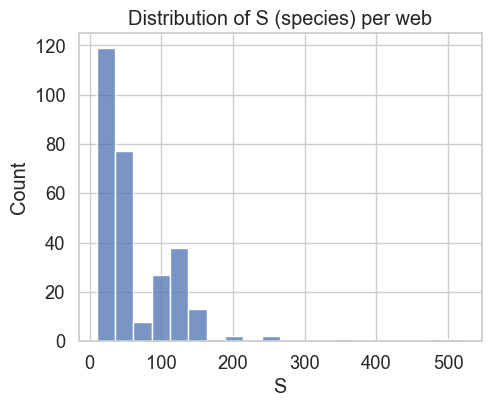

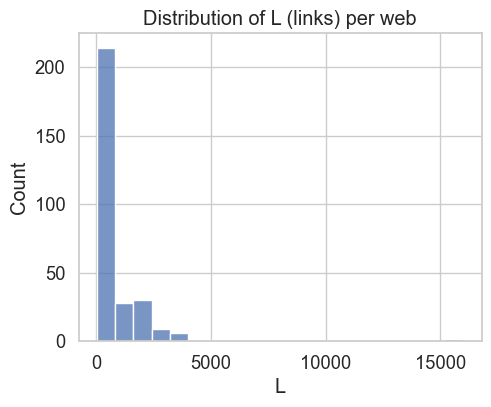

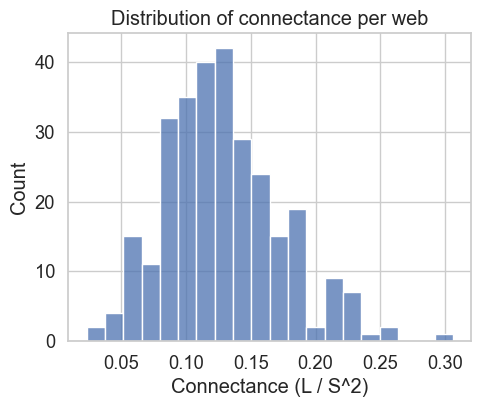

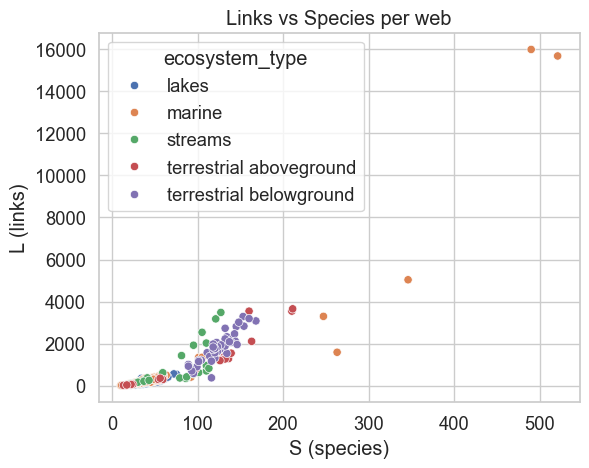

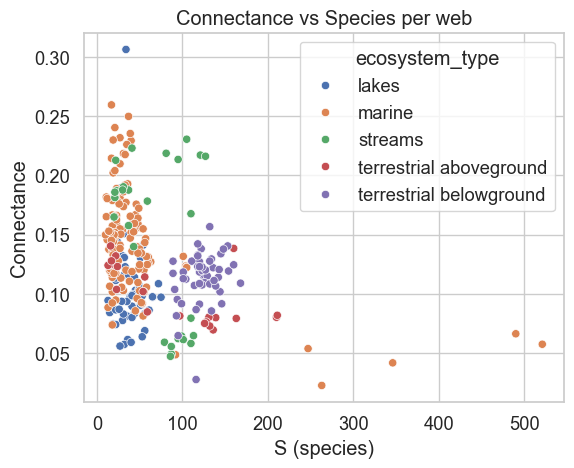

In [18]:
# S distribution
plt.figure(figsize=(5.2,4))
sns.histplot(per_web_df["S_species"], bins=20, edgecolor=None)
plt.title("Distribution of S (species) per web")
plt.xlabel("S"); plt.ylabel("Count")
plt.show()

# L distribution
plt.figure(figsize=(5.2,4))
sns.histplot(per_web_df["L_links"], bins=20, edgecolor=None)
plt.title("Distribution of L (links) per web")
plt.xlabel("L"); plt.ylabel("Count")
plt.show()

# Connectance distribution
plt.figure(figsize=(5.2,4))
sns.histplot(per_web_df["connectance"].dropna(), bins=20, edgecolor=None)
plt.title("Distribution of connectance per web")
plt.xlabel("Connectance (L / S^2)"); plt.ylabel("Count")
plt.show()

# S vs L (by ecosystem)
plt.figure(figsize=(6.2,4.8))
sns.scatterplot(data=per_web_df, x="S_species", y="L_links", hue="ecosystem_type")
plt.title("Links vs Species per web")
plt.xlabel("S (species)"); plt.ylabel("L (links)")
plt.show()

# S vs connectance (by ecosystem)
plt.figure(figsize=(6.2,4.8))
sns.scatterplot(data=per_web_df, x="S_species", y="connectance", hue="ecosystem_type")
plt.title("Connectance vs Species per web")
plt.xlabel("S (species)"); plt.ylabel("Connectance")
plt.show()

## 11) Degree distributions (global and per-web examples)

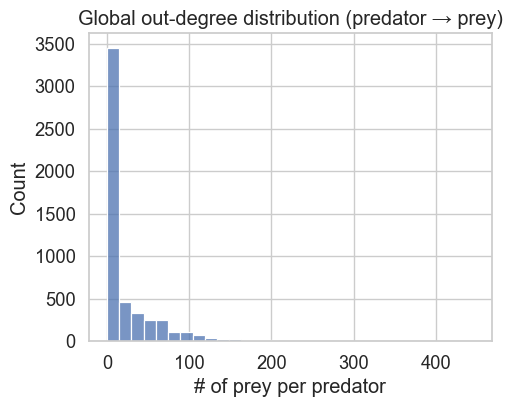

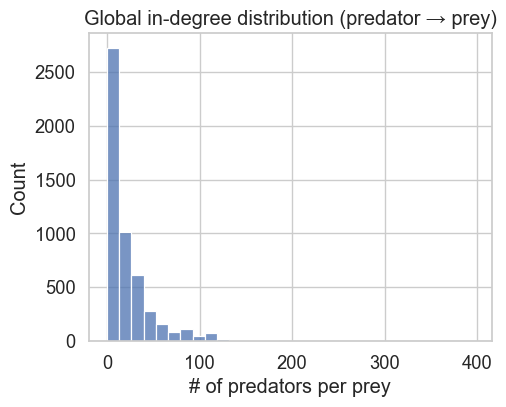

In [19]:
# Global graph (across all webs)
G_all = nx.DiGraph()
G_all.add_nodes_from(global_species.tolist())
G_all.add_edges_from(edges[["predator","prey"]].itertuples(index=False, name=None))

in_deg_all  = np.array([d for _, d in G_all.in_degree()])
out_deg_all = np.array([d for _, d in G_all.out_degree()])

plt.figure(figsize=(5.2,4))
sns.histplot(out_deg_all, bins=30, edgecolor=None)
plt.title("Global out-degree distribution (predator → prey)")
plt.xlabel("# of prey per predator"); plt.ylabel("Count")
plt.show()

plt.figure(figsize=(5.2,4))
sns.histplot(in_deg_all, bins=30, edgecolor=None)
plt.title("Global in-degree distribution (predator → prey)")
plt.xlabel("# of predators per prey"); plt.ylabel("Count")
plt.show()

## 12) Trophic levels per web (linear system; basal = 1) + mean TL

In [20]:
def trophic_levels_linear(G: nx.DiGraph) -> pd.Series:
    nodes_ = list(G.nodes())
    idx = {n:i for i,n in enumerate(nodes_)}
    n = len(nodes_)
    if n == 0:
        return pd.Series(dtype=float)

    A = np.zeros((n, n), dtype=float)
    out_deg = np.array([G.out_degree(x) for x in nodes_], dtype=float)
    for u, v in G.edges():
        A[idx[u], idx[v]] = 1.0

    D = np.zeros_like(A)
    for i in range(n):
        if out_deg[i] > 0:
            D[i, :] = A[i, :] / out_deg[i]
        else:
            D[i, :] = 0.0

    I_minus_D = np.eye(n) - D
    b = np.ones(n)

    basal_idx = np.where(out_deg == 0)[0]
    for i in basal_idx:
        I_minus_D[i, :] = 0.0
        I_minus_D[i, i] = 1.0
        b[i] = 1.0

    try:
        s = np.linalg.solve(I_minus_D, b)
    except np.linalg.LinAlgError:
        s, *_ = np.linalg.lstsq(I_minus_D, b, rcond=None)

    return pd.Series(s, index=nodes_, name="trophic_level")

# Compute per-web trophic levels and attach mean TL
tl_frames = []
mean_tl_rows = []
for w, sub in edges.groupby("web", dropna=False):
    G = nx.DiGraph()
    sp = pd.unique(sub[["predator","prey"]].values.ravel("K"))
    G.add_nodes_from(sp.tolist())
    G.add_edges_from(sub[["predator","prey"]].itertuples(index=False, name=None))
    tl = trophic_levels_linear(G)
    tl_df = tl.reset_index().rename(columns={"index":"species"})
    tl_df["web"] = w
    tl_frames.append(tl_df)

    mean_tl_rows.append({"web": w, "mean_tl": float(tl.mean()) if len(tl) else np.nan})

trophic_levels = pd.concat(tl_frames, ignore_index=True) if tl_frames else pd.DataFrame(columns=["species","trophic_level","web"])
mean_tl_df = pd.DataFrame(mean_tl_rows)

per_web_df = per_web_df.merge(mean_tl_df, on="web", how="left")
per_web_df.sort_values(["ecosystem_type","web"]).reset_index(drop=True)

,web,ecosystem_type,S_species,L_links,connectance,in_deg_mean,in_deg_max,out_deg_mean,out_deg_max,deg_mean,deg_max,mean_tl
0,Alford lake,lakes,56,217,0.069196,3.875000,21,3.875000,34,7.750000,35,1.701031
1,Balsam lake,lakes,50,258,0.103200,5.160000,14,5.160000,30,10.320000,30,1.587057
2,Beaver lake,lakes,56,262,0.083546,4.678571,14,4.678571,26,9.357143,32,1.673525
3,Big hope lake,lakes,61,322,0.086536,5.278689,22,5.278689,33,10.557377,37,1.768853
4,Brandy lake,lakes,30,119,0.132222,3.966667,15,3.966667,24,7.933333,24,1.922186
...,...,...,...,...,...,...,...,...,...,...,...,...
285,SEW36,terrestrial belowground,89,931,0.117536,10.460674,29,10.460674,34,20.921348,47,3.591071
286,SEW37,terrestrial belowground,118,1982,0.142344,16.796610,33,16.796610,65,33.593220,90,3.618244
287,SEW41,terrestrial belowground,118,1717,0.123312,14.550847,40,14.550847,67,29.101695,94,3.597833
288,SEW43,terrestrial belowground,120,1773,0.123125,14.775000,40,14.775000,67,29.550000,94,3.640198


## 13) Metadata completeness snapshot

In [21]:
def completeness(series: pd.Series) -> float:
    return float(series.notna().mean()) * 100.0

completeness_report = pd.DataFrame({
    "column": ["longitude","latitude","interaction.type","interaction.classification","interaction.dimensionality","ecosystem.type","study.site"],
    "completeness_%": [
        completeness(edges["longitude"]),
        completeness(edges["latitude"]),
        completeness(edges["interaction_type"]),
        completeness(edges["interaction_class"]),
        completeness(edges["interaction_dim"]),
        completeness(edges["ecosystem_type"]),
        completeness(edges["study_site"]),
    ]
})
completeness_report

,column,completeness_%
0,longitude,100.000000
1,latitude,100.000000
2,interaction.type,99.232403
3,interaction.classification,99.606089
4,interaction.dimensionality,91.741205
5,ecosystem.type,100.000000
6,study.site,100.000000


## 14) Quick geospatial sanity plot

In [22]:
has_geo = edges["longitude"].notna() & edges["latitude"].notna()
if has_geo.any():
    g = edges.loc[has_geo, ["latitude","longitude","ecosystem_type","web","study_site"]].copy()
    g["ecosystem_type"] = g["ecosystem_type"].fillna("unknown")

    # Center map on data mean
    center = [g["latitude"].mean(), g["longitude"].mean()]
    m = folium.Map(location=center, zoom_start=4, tiles="CartoDB positron")

    # Simple categorical palette
    base_colors = [
        "#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd",
        "#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf"
    ]
    ecos = g["ecosystem_type"].unique().tolist()
    color_map = dict(zip(ecos, itertools.cycle(base_colors)))

    # Add points
    for _, r in g.iterrows():
        folium.CircleMarker(
            location=[r["latitude"], r["longitude"]],
            radius=4,
            color=color_map[r["ecosystem_type"]],
            fill=True,
            fill_opacity=0.85,
            popup=f'{r["web"]} – {r["study_site"]} ({r["ecosystem_type"]})'
        ).add_to(m)

    # Save and display
    m.save("sampling_locations_folium.html")
    m

## 15) Tables to export

In [23]:
# Export CSV if desired
edges.to_csv(os.path.join(OUT_DIR, "edges.csv"), index=False)
nodes.to_csv(os.path.join(OUT_DIR, "nodes.csv"), index=False)
per_web_df.to_csv(os.path.join(OUT_DIR, "per_web_summary.csv"), index=False)
trophic_levels.to_csv(os.path.join(OUT_DIR, "trophic_levels.csv"), index=False)

print("Saved to:", os.path.abspath(OUT_DIR))

Saved to: /Users/jorge/Documents/qmul-phd-framework/data/processed/notebooks/gateway_processed
